<a href="https://colab.research.google.com/github/lutfiarda22/Isparta-Acil-durum-drone-KKalgoritmasi/blob/main/acoIspartaDroneKKalgoritma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BLG-307 Yapay Zeka Sistemleri – Proje 2
## Karınca Kolonisi Algoritması ile Yol Optimizasyonu (Senaryo 8)
**AD SOYAD:Lütfi Arda Karaoğlu**

**Okul Numarası:2212721038**

Bu colab notebookta, Isparta merkezdeki afet ve acil durum toplanma alanlarına
paket taşıyan bir acil durum dronunun **en uygun rotasını** bulmak için
Karınca Kolonisi Algoritması (ACO) uygulanmaktadır.


In [41]:
!pip install googlemaps
import googlemaps
import math
import random
import matplotlib.pyplot as plt
import numpy as np




In [42]:
locations = [
    {"name": "Çünür Üniversite Cad. Park", "lat": 37.78422, "lng": 30.56492},
    {"name": "Çünür Gülkent Kapalı Pazar", "lat": 37.78460, "lng": 30.55390},
    {"name": "Modernevler Kapalı Pazaryeri", "lat": 37.77450, "lng": 30.55170},
    {"name": "Işıkkent Mehmet Tönge Parkı", "lat": 37.77080, "lng": 30.54940},
    {"name": "Karaağaç Kaymakkapı Meydanı", "lat": 37.76610, "lng": 30.55230},
    {"name": "15 Temmuz Meydanı",       "lat": 37.76540, "lng": 30.55280},
    {"name": "Bahçelievler Pazar Yeri", "lat": 37.76080, "lng": 30.54410},
    {"name": "Sanayi Mah. Otoparkı",    "lat": 37.76950, "lng": 30.53680},
]

n_cities = len(locations)


In [43]:
from google.colab import userdata
API_KEY = userdata.get("API_KEY")
gmaps = googlemaps.Client(key=API_KEY)

def get_distance(lat1, lng1, lat2, lng2):
    result = gmaps.distance_matrix(
        [(lat1, lng1)],
        [(lat2, lng2)],
        mode="driving",
        units="metric"
    )
    return result["rows"][0]["elements"][0]["distance"]["value"] / 1000


In [44]:
distance_matrix = [[0]*n_cities for _ in range(n_cities)]

for i in range(n_cities):
    for j in range(n_cities):
        if i != j:
            distance_matrix[i][j] = get_distance(
                locations[i]["lat"], locations[i]["lng"],
                locations[j]["lat"], locations[j]["lng"]
            )

distance_matrix


[[0, 1.919, 3.04, 3.228, 4.325, 4.581, 5.236, 5.101],
 [2.411, 0, 1.419, 2.103, 2.703, 2.959, 3.614, 3.112],
 [2.742, 1.442, 0, 0.875, 1.358, 1.614, 2.68, 2.178],
 [2.63, 2.124, 0.731, 0, 0.908, 1.565, 1.813, 1.611],
 [3.205, 2.994, 1.601, 1.097, 0, 0.326, 1.488, 2.031],
 [3.072, 2.861, 1.468, 0.959, 0.139, 0, 1.635, 2.062],
 [4.498, 3.628, 2.507, 1.907, 1.642, 1.503, 0, 1.81],
 [4.14, 3.612, 1.933, 1.548, 2.235, 2.768, 2.031, 0]]

In [45]:
num_ants = 20
num_iterations = 50
alpha = 1
beta = 2
evaporation = 0.5


In [46]:
def generate_route(pheromone, heuristic):
    start = random.randint(0, n_cities - 1)
    route = [start]
    visited = {start}

    while len(route) < n_cities:
        current = route[-1]
        probs = []
        for city in range(n_cities):
            if city in visited:
                probs.append(0)
            else:
                probs.append(pheromone[current][city] * (heuristic[current][city] ** beta))

        total = sum(probs)
        if total == 0:
            next_city = random.choice(list(set(range(n_cities)) - visited))
        else:
            probs = [p / total for p in probs]
            next_city = random.choices(range(n_cities), weights=probs)[0]

        route.append(next_city)
        visited.add(next_city)

    return route


def route_distance(route):
    total = sum(distance_matrix[route[i]][route[i+1]] for i in range(len(route)-1))
    total += distance_matrix[route[-1]][route[0]]
    return total


def update_pheromones(pheromone, routes, distances):
    for i in range(n_cities):
        for j in range(n_cities):
            pheromone[i][j] *= (1 - evaporation)

    for route, dist in zip(routes, distances):
        deposit = 1 / dist
        for k in range(len(route)-1):
            a, b = route[k], route[k+1]
            pheromone[a][b] += deposit
            pheromone[b][a] += deposit
        pheromone[route[-1]][route[0]] += deposit


In [47]:
pheromone = [[1]*n_cities for _ in range(n_cities)]
heuristic = [[1/distance_matrix[i][j] if distance_matrix[i][j] != 0 else 0
              for j in range(n_cities)] for i in range(n_cities)]

best_route = None
best_distance = float("inf")
distance_progress = []

for it in range(num_iterations):
    routes = []
    distances = []

    for _ in range(num_ants):
        route = generate_route(pheromone, heuristic)
        d = route_distance(route)
        routes.append(route)
        distances.append(d)

        if d < best_distance:
            best_route = route
            best_distance = d

    update_pheromones(pheromone, routes, distances)
    distance_progress.append(best_distance)

best_route, best_distance


([0, 1, 2, 4, 5, 6, 7, 3], 12.645)

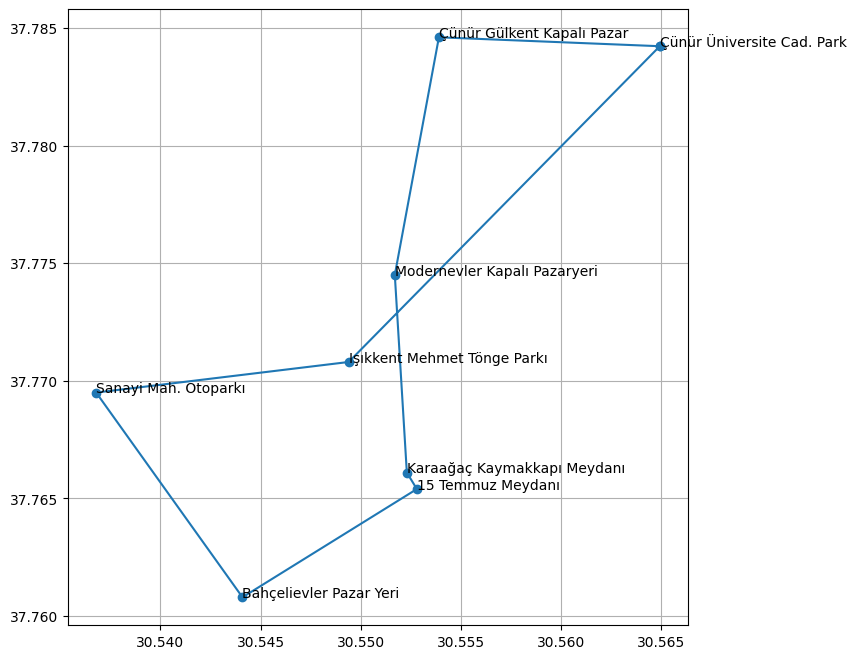

In [48]:
def plot_route(route):
    xs = [locations[i]["lng"] for i in route] + [locations[route[0]]["lng"]]
    ys = [locations[i]["lat"] for i in route] + [locations[route[0]]["lat"]]

    plt.figure(figsize=(8,8))
    plt.plot(xs, ys, marker='o')
    for i in route:
        plt.text(locations[i]["lng"], locations[i]["lat"], locations[i]["name"])
    plt.grid()
    plt.show()

plot_route(best_route)


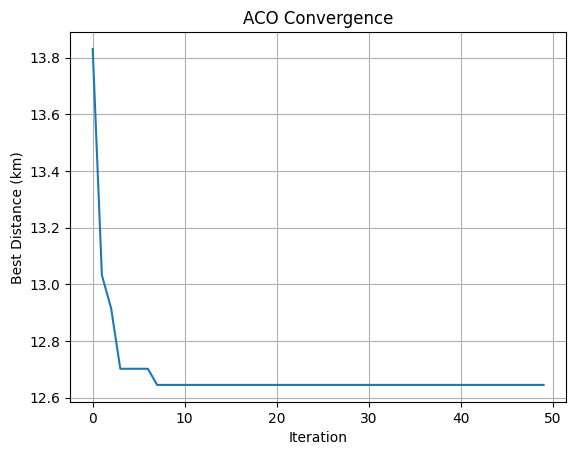

In [49]:
plt.plot(distance_progress)
plt.xlabel("Iteration")
plt.ylabel("Best Distance (km)")
plt.title("ACO Convergence")
plt.grid(True)
plt.show()


In [50]:
import folium

# Harita merkezi (ortalama koordinat)
center_lat = np.mean([loc["lat"] for loc in locations])
center_lng = np.mean([loc["lng"] for loc in locations])

m = folium.Map(
    location=[center_lat, center_lng],
    zoom_start=13
)

# Markerlar
for idx, loc in enumerate(locations):
    folium.Marker(
        location=[loc["lat"], loc["lng"]],
        popup=f"{idx} - {loc['name']}",
        tooltip=str(idx)
    ).add_to(m)

# Rota (kapalı tur)
route_points = [(locations[i]["lat"], locations[i]["lng"]) for i in best_route]
route_points.append(route_points[0])  # başlangıca dönüş

folium.PolyLine(
    route_points,
    color="red",
    weight=5,
    opacity=0.8
).add_to(m)

m


# 📌 Projenin Amacı ve Sonuç

Bu çalışmada, Isparta merkezde bulunan acil durum toplanma alanları arasında bir dronun takip edebileceği
**en kısa rotanın belirlenmesi** amaçlanmıştır. Rota optimizasyonu, özellikle afet ve acil durum senaryolarında
kritik öneme sahiptir. Dronlar, karayolu trafiğinden etkilenmediği için hızlı ve güvenli bir şekilde ilaç,
ilk yardım kitleri veya acil ihtiyaç malzemeleri taşıyabilir.

Bu nedenle projede:

- Toplanma alanlarının **gerçek koordinatları** alınmış,
- Lokasyonlar arası mesafeler **Google Maps Distance Matrix API** kullanılarak “driving distance” üzerinden hesaplanmış,
- En uygun rotanın belirlenmesi için **Karınca Kolonisi Algoritması (Ant Colony Optimization - ACO)** uygulanmıştır.

Sonuç olarak algoritma:

- Çok sayıda olası rota arasından en kısa toplam mesafeyi bulmuş,
- İterasyonlar boyunca **yakınsama davranışı** grafiği ile analiz edilmiş,
- En iyi rota **harita üzerinde görselleştirilmiştir.**

Bu proje, hem gerçek veriler hem de optimizasyon algoritmaları kullanılarak **afet lojistiğinde dronların rota planlamasına yönelik pratik bir çözüm sunmaktadır.**
